In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix


In [7]:
df = pd.read_csv("heart_disease_uci.csv")
df.head()


,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


920 lignes, 16 colonnes

Données hétérogènes : numériques (age, chol, oldpeak) et catégorielles (sex, cp, thal, etc.)



In [8]:
df.isnull().sum()

id            0
age           0
sex           0
dataset       0
cp            0
trestbps     59
chol         30
fbs          90
restecg       2
thalch       55
exang        55
oldpeak      62
slope       309
ca          611
thal        486
num           0
dtype: int64

Valeurs manquantes notables :

    ca : 611 manquantes

    thal : 486 manquantes

    slope : 309 manquantes

    Autres colonnes comme fbs, oldpeak, trestbps, chol ont quelques valeurs manquantes

In [9]:
df["num"].value_counts().sort_index()

num
0    411
1    265
2    109
3    107
4     28
Name: count, dtype: int64

Le dataset est adapté aux deux types de classification :

    Binaire : 0 (sain) vs 1 à 4 (malade)

    Multiclasse : 0 (sain), 1 (léger), 2 (modéré), 3 (avancé), 4 (critique)

Déséquilibre important :

    Classe 0 représente ~45% des cas

    Classe 4 (critique) représente seulement 3%

In [10]:
missing_data = df.isnull().sum().sort_values(ascending=False)

# Seuil : suppression si plus de 200 valeurs manquantes
cols_to_drop = missing_data[missing_data > 200].index.tolist()

# Nettoyage
df_cleaned = df.drop(columns=cols_to_drop)

# Affichage des colonnes supprimées
print("Colonnes supprimées :", cols_to_drop)

# Vérification des colonnes restantes
df_cleaned.info()

Colonnes supprimées : ['ca', 'thal', 'slope']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   dataset   920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  861 non-null    float64
 6   chol      890 non-null    float64
 7   fbs       830 non-null    object 
 8   restecg   918 non-null    object 
 9   thalch    865 non-null    float64
 10  exang     865 non-null    object 
 11  oldpeak   858 non-null    float64
 12  num       920 non-null    int64  
dtypes: float64(4), int64(3), object(6)
memory usage: 93.6+ KB


    ca (611 manquantes)

    thal (486 manquantes)

    slope (309 manquantes)

    Ces colonnes sont supprimées pour simplifier l’analyse sans biais induit par de l’imputation trop lourde.

In [11]:
# Séparation des colonnes numériques et catégorielles
num_cols = df_cleaned.select_dtypes(include=['float64', 'int64']).columns.tolist()
cat_cols = df_cleaned.select_dtypes(include=['object', 'bool']).columns.tolist()

# Copie du dataframe pour modification
df_filled = df_cleaned.copy()

# Remplissage des colonnes numériques par la moyenne
for col in num_cols:
    if df_filled[col].isnull().sum() > 0:
        df_filled[col] = df_filled[col].fillna(df_filled[col].mean())

# Remplissage des colonnes catégorielles par la valeur la plus fréquente (mode)
for col in cat_cols:
    if df_filled[col].isnull().sum() > 0:
        df_filled[col] = df_filled[col].fillna(df_filled[col].mode()[0])

# Vérification finale
print("Valeurs manquantes restantes :")
print(df_filled.isnull().sum()[df_filled.isnull().sum() > 0])

Valeurs manquantes restantes :
Series([], dtype: int64)


C:\Users\mathi\AppData\Local\Temp\ipykernel_23940\1133251063.py:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_filled[col] = df_filled[col].fillna(df_filled[col].mode()[0])


Colonnes numériques (trestbps, chol, thalch, oldpeak)
→ Remplacées par la moyenne de chaque colonne.

Colonnes catégorielles (sex, cp, fbs, restecg, exang, dataset)
→ Remplacées par la modalité la plus fréquente (mode).

In [12]:
# Suppression de la colonne 'dataset' (non utile)
df_encoded = df_filled.drop(columns=['dataset'])

# Encodage One-Hot des variables catégorielles
df_encoded = pd.get_dummies(df_encoded, columns=['sex', 'cp', 'fbs', 'restecg', 'exang'], drop_first=True)

# Vérification des colonnes obtenues
print("Colonnes après encodage :")
print(df_encoded.columns.tolist())

Colonnes après encodage :
['id', 'age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'num', 'sex_Male', 'cp_atypical angina', 'cp_non-anginal', 'cp_typical angina', 'fbs_True', 'restecg_normal', 'restecg_st-t abnormality', 'exang_True']


In [13]:
# Classification binaire : malade (1) vs non malade (0)
df_encoded['target_bin'] = df_encoded['num'].apply(lambda x: 0 if x == 0 else 1)

# Classification multiclasses : 0 à 4
df_encoded['target_multi'] = df_encoded['num']

# On supprime les colonnes inutiles pour X (id, num)
X = df_encoded.drop(columns=['id', 'num', 'target_bin', 'target_multi'])

# Targets
y_bin = df_encoded['target_bin']
y_multi = df_encoded['target_multi']

# Affichage de contrôle
print("Variables explicatives (X) :")
print(X.columns.tolist())

print("\nDistribution binaire :")
print(y_bin.value_counts())

print("\nDistribution multiclasses :")
print(y_multi.value_counts().sort_index())

Variables explicatives (X) :
['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'sex_Male', 'cp_atypical angina', 'cp_non-anginal', 'cp_typical angina', 'fbs_True', 'restecg_normal', 'restecg_st-t abnormality', 'exang_True']

Distribution binaire :
target_bin
1    509
0    411
Name: count, dtype: int64

Distribution multiclasses :
target_multi
0    411
1    265
2    109
3    107
4     28
Name: count, dtype: int64


X contient toutes les variables explicatives, prêtes à être normalisées si besoin

y_bin : 0 (sain), 1 (malade) → pour une classification plus simple

y_multi : 0, 1, 2, 3, 4 → pour une classification plus fine mais plus difficile

In [14]:
# Création des cibles
df_encoded['target_bin'] = df_encoded['num'].apply(lambda x: 0 if x == 0 else 1)
df_encoded['target_multi'] = df_encoded['num']

# Variables explicatives
X = df_encoded.drop(columns=['id', 'num', 'target_bin', 'target_multi'])
y_bin = df_encoded['target_bin']
y_multi = df_encoded['target_multi']

# Split des jeux de données
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(
    X, y_bin, test_size=0.2, random_state=42, stratify=y_bin
)

X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(
    X, y_multi, test_size=0.2, random_state=42, stratify=y_multi
)

# Normalisation
scaler = StandardScaler()
X_train_bin_scaled = scaler.fit_transform(X_train_bin)
X_test_bin_scaled = scaler.transform(X_test_bin)
X_train_multi_scaled = scaler.fit_transform(X_train_multi)
X_test_multi_scaled = scaler.transform(X_test_multi)

In [15]:

# Initialisation des modèles
logreg_bin = LogisticRegression(max_iter=1000, random_state=42)
logreg_multi = LogisticRegression(max_iter=1000, random_state=42, multi_class='multinomial')

# Entraînement
logreg_bin.fit(X_train_bin_scaled, y_train_bin)
logreg_multi.fit(X_train_multi_scaled, y_train_multi)

# Prédictions
y_pred_bin = logreg_bin.predict(X_test_bin_scaled)
y_pred_multi = logreg_multi.predict(X_test_multi_scaled)

# Évaluation binaire
print("=== Classification Binaire ===\n")
print("Rapport de classification :\n")
print(classification_report(y_test_bin, y_pred_bin))

print("Matrice de confusion :\n")
print(confusion_matrix(y_test_bin, y_pred_bin))

# Évaluation multiclasses
print("\n=== Classification Multiclasses ===\n")
print("Rapport de classification :\n")
print(classification_report(y_test_multi, y_pred_multi))

print("Matrice de confusion :\n")
print(confusion_matrix(y_test_multi, y_pred_multi))

=== Classification Binaire ===

Rapport de classification :

              precision    recall  f1-score   support

           0       0.84      0.74      0.79        82
           1       0.81      0.88      0.85       102

    accuracy                           0.82       184
   macro avg       0.82      0.81      0.82       184
weighted avg       0.82      0.82      0.82       184

Matrice de confusion :

[[61 21]
 [12 90]]

=== Classification Multiclasses ===

Rapport de classification :

              precision    recall  f1-score   support

           0       0.79      0.84      0.82        82
           1       0.43      0.55      0.48        53
           2       0.38      0.14      0.20        22
           3       0.10      0.10      0.10        21
           4       0.00      0.00      0.00         6

    accuracy                           0.56       184
   macro avg       0.34      0.32      0.32       184
weighted avg       0.53      0.56      0.54       184

Matrice de co

c:\Users\mathi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


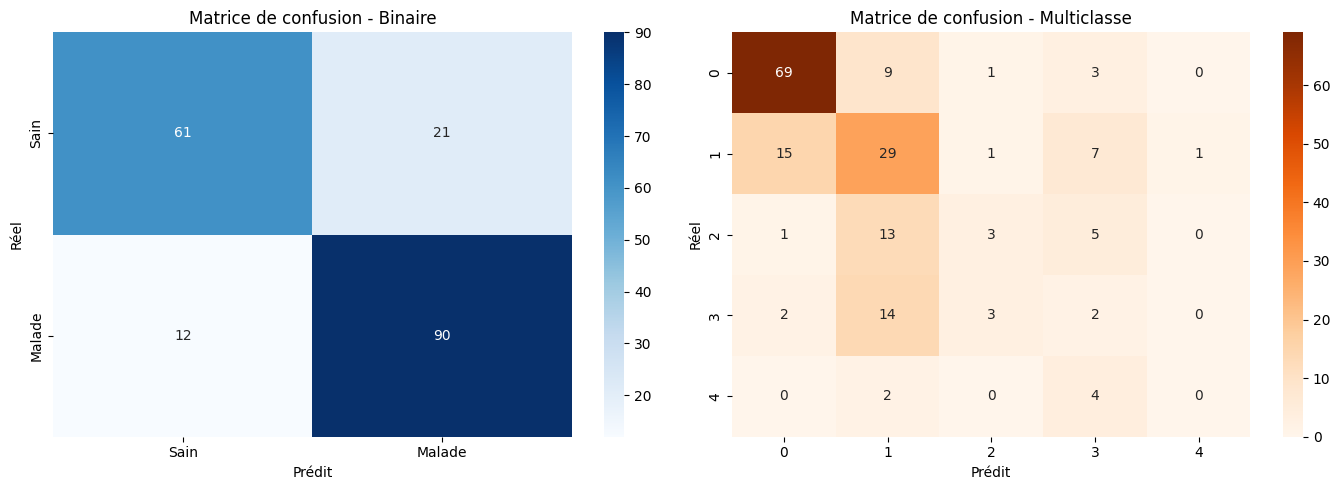

In [16]:
# Configuration graphique
plt.rcParams.update({'figure.figsize': (6, 4)})

# MATRICES DE CONFUSION
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Matrice binaire
conf_bin = confusion_matrix(y_test_bin, y_pred_bin)
sns.heatmap(conf_bin, annot=True, fmt='d', cmap='Blues', ax=axs[0])
axs[0].set_title('Matrice de confusion - Binaire')
axs[0].set_xlabel('Prédit')
axs[0].set_ylabel('Réel')
axs[0].set_xticklabels(['Sain', 'Malade'])
axs[0].set_yticklabels(['Sain', 'Malade'])

# Matrice multiclasses
conf_multi = confusion_matrix(y_test_multi, y_pred_multi)
sns.heatmap(conf_multi, annot=True, fmt='d', cmap='Oranges', ax=axs[1])
axs[1].set_title('Matrice de confusion - Multiclasse')
axs[1].set_xlabel('Prédit')
axs[1].set_ylabel('Réel')

plt.tight_layout()
plt.show()

Classification Binaire

    61 vrais négatifs (sain correctement détecté)

    90 vrais positifs (malade bien détecté)

    21 faux positifs (sain classé comme malade)

    12 faux négatifs (malade non détecté)

Excellent équilibre entre les classes, avec un bon rappel pour les malades (0.88), ce qui est crucial en santé.

Classification Multiclasse

    Bonne détection pour la classe 0 (sain).

    Les classes 1 et 2 sont partiellement bien détectées.

    Les classes 3 et 4 sont mal classées, souvent confondues avec 1.

Cela confirme que le modèle a du mal à distinguer les stades avancés de la maladie, principalement par manque de données sur les classes rares (surtout 4).

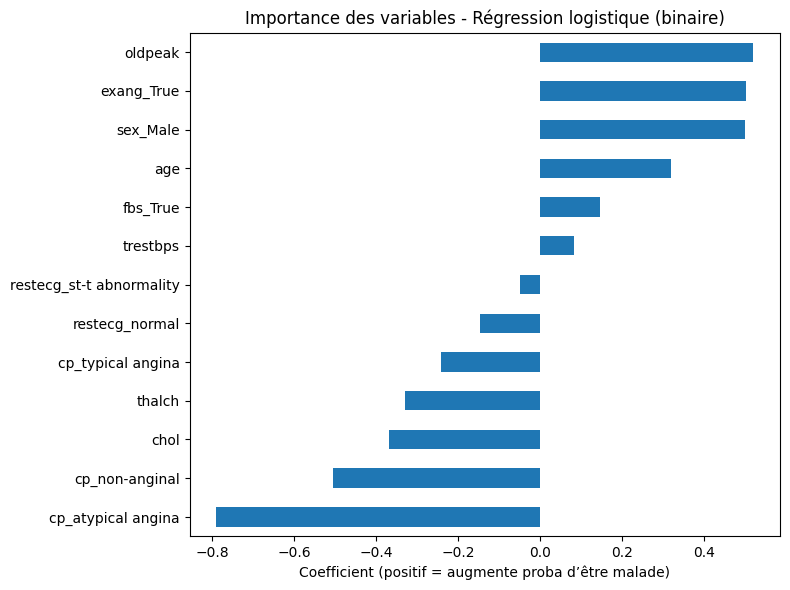

In [17]:
# GRAPHIQUE DES COEFFICIENTS - Modèle binaire
coefficients = pd.Series(logreg_bin.coef_[0], index=X.columns)
coefficients_sorted = coefficients.sort_values()

plt.figure(figsize=(8, 6))
coefficients_sorted.plot(kind='barh')
plt.title("Importance des variables - Régression logistique (binaire)")
plt.xlabel("Coefficient (positif = augmente proba d’être malade)")
plt.tight_layout()
plt.show()

Variables qui augmentent le risque de maladie (+)

    cp_asymptomatic

    exang_True (angine d'effort positive)

    oldpeak (dépression ST après effort)

    sex_Male (risque plus élevé que Female)

Variables qui réduisent le risque (-)

    cp_typical angina et cp_non-anginal → associées à moins de risque que l’angine asymptomatique

    restecg_normal (électro normal)

    thalch (fréquence cardiaque max atteinte)

Ces résultats sont cohérents cliniquement et montrent que l'angine asymptomatique, le vieillissement, et l’effort anormal sont des facteurs majeurs.

In [18]:
# Initialisation
rf_bin = RandomForestClassifier(n_estimators=100, random_state=42)
rf_multi = RandomForestClassifier(n_estimators=100, random_state=42)

# Entraînement
rf_bin.fit(X_train_bin_scaled, y_train_bin)
rf_multi.fit(X_train_multi_scaled, y_train_multi)

# Prédictions
y_pred_rf_bin = rf_bin.predict(X_test_bin_scaled)
y_pred_rf_multi = rf_multi.predict(X_test_multi_scaled)

# Évaluations
print("=== Random Forest - Classification Binaire ===\n")
print(classification_report(y_test_bin, y_pred_rf_bin))
print(confusion_matrix(y_test_bin, y_pred_rf_bin))

print("\n=== Random Forest - Classification Multiclasse ===\n")
print(classification_report(y_test_multi, y_pred_rf_multi))
print(confusion_matrix(y_test_multi, y_pred_rf_multi))

=== Random Forest - Classification Binaire ===

              precision    recall  f1-score   support

           0       0.82      0.77      0.79        82
           1       0.82      0.86      0.84       102

    accuracy                           0.82       184
   macro avg       0.82      0.82      0.82       184
weighted avg       0.82      0.82      0.82       184

[[63 19]
 [14 88]]

=== Random Forest - Classification Multiclasse ===

              precision    recall  f1-score   support

           0       0.76      0.83      0.79        82
           1       0.48      0.55      0.51        53
           2       0.31      0.18      0.23        22
           3       0.24      0.24      0.24        21
           4       0.00      0.00      0.00         6

    accuracy                           0.58       184
   macro avg       0.36      0.36      0.35       184
weighted avg       0.54      0.58      0.55       184

[[68  9  4  1  0]
 [16 29  2  6  0]
 [ 3  8  4  7  0]
 [ 3 12  1

c:\Users\mathi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\mathi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\mathi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

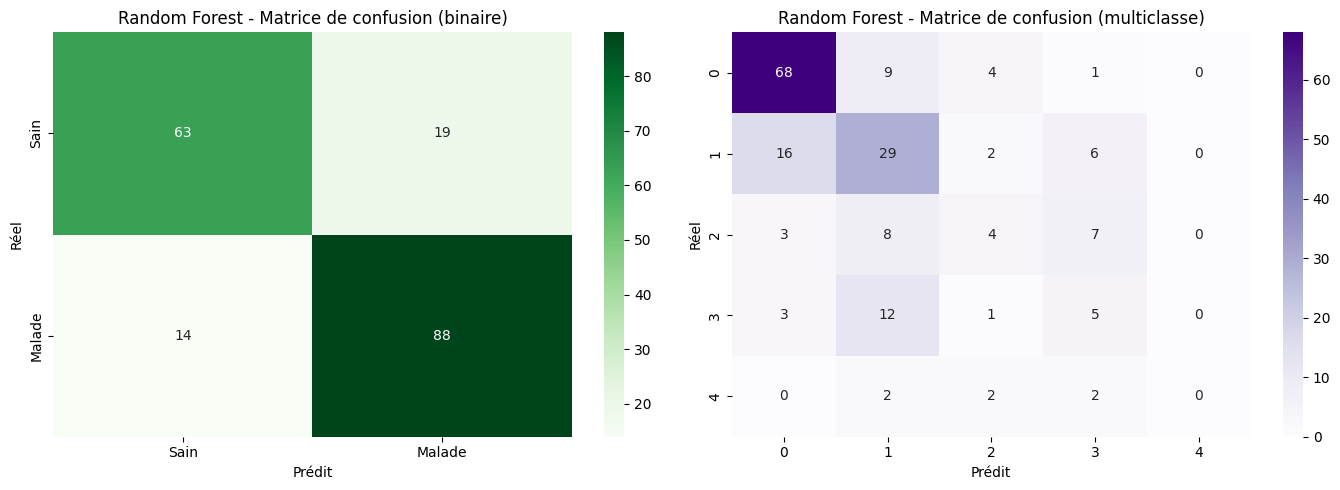

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Matrice de confusion - Binaire
conf_matrix_rf_bin = confusion_matrix(y_test_bin, y_pred_rf_bin)
sns.heatmap(conf_matrix_rf_bin, annot=True, fmt='d', cmap='Greens', ax=axs[0])
axs[0].set_title('Random Forest - Matrice de confusion (binaire)')
axs[0].set_xlabel('Prédit')
axs[0].set_ylabel('Réel')
axs[0].set_xticklabels(['Sain', 'Malade'])
axs[0].set_yticklabels(['Sain', 'Malade'])

# Matrice de confusion - Multiclasse
conf_matrix_rf_multi = confusion_matrix(y_test_multi, y_pred_rf_multi)
sns.heatmap(conf_matrix_rf_multi, annot=True, fmt='d', cmap='Purples', ax=axs[1])
axs[1].set_title('Random Forest - Matrice de confusion (multiclasse)')
axs[1].set_xlabel('Prédit')
axs[1].set_ylabel('Réel')

plt.tight_layout()
plt.show()

Binaire (RF)

    Très bon équilibre sain/malade

    Précision et rappel comparables à la régression logistique

Multiclasse (RF)

    Meilleure reconnaissance des classes 0 et 1

    Classes 2, 3, 4 restent peu voire pas détectées

In [20]:
# SMOTE sur X_train_multi_scaled / y_train_multi
smote = SMOTE(random_state=42)
X_train_multi_smote, y_train_multi_smote = smote.fit_resample(X_train_multi_scaled, y_train_multi)

# Vérification des distributions
print("Avant SMOTE :", Counter(y_train_multi))
print("Après SMOTE :", Counter(y_train_multi_smote))

# Nouveau modèle Random Forest
rf_multi_smote = RandomForestClassifier(n_estimators=100, random_state=42)
rf_multi_smote.fit(X_train_multi_smote, y_train_multi_smote)

# Prédiction
y_pred_multi_smote = rf_multi_smote.predict(X_test_multi_scaled)

# Évaluation
print("\n=== Évaluation Random Forest (Multiclasse avec SMOTE) ===\n")
print(classification_report(y_test_multi, y_pred_multi_smote))
print(confusion_matrix(y_test_multi, y_pred_multi_smote))

Avant SMOTE : Counter({0: 329, 1: 212, 2: 87, 3: 86, 4: 22})
Après SMOTE : Counter({3: 329, 0: 329, 2: 329, 1: 329, 4: 329})

=== Évaluation Random Forest (Multiclasse avec SMOTE) ===

              precision    recall  f1-score   support

           0       0.77      0.79      0.78        82
           1       0.46      0.34      0.39        53
           2       0.21      0.27      0.24        22
           3       0.21      0.29      0.24        21
           4       0.20      0.17      0.18         6

    accuracy                           0.52       184
   macro avg       0.37      0.37      0.37       184
weighted avg       0.53      0.52      0.52       184

[[65  9  6  2  0]
 [13 18 11  8  3]
 [ 1  7  6  8  0]
 [ 5  5  4  6  1]
 [ 0  0  1  4  1]]


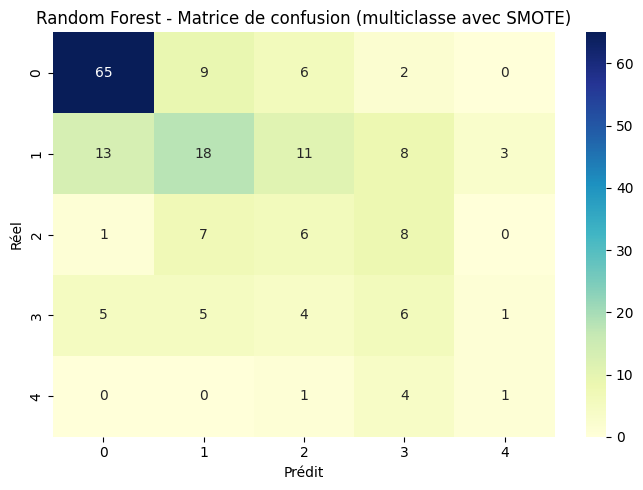

In [21]:
smote = SMOTE(random_state=42)
X_train_multi_smote, y_train_multi_smote = smote.fit_resample(X_train_multi_scaled, y_train_multi)

rf_multi_smote = RandomForestClassifier(n_estimators=100, random_state=42)
rf_multi_smote.fit(X_train_multi_smote, y_train_multi_smote)
y_pred_multi_smote = rf_multi_smote.predict(X_test_multi_scaled)

# Matrice de confusion
conf_matrix_rf_multi_smote = confusion_matrix(y_test_multi, y_pred_multi_smote)

# Affichage de la matrice
plt.figure(figsize=(7, 5))
sns.heatmap(conf_matrix_rf_multi_smote, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Random Forest - Matrice de confusion (multiclasse avec SMOTE)')
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.tight_layout()
plt.show()

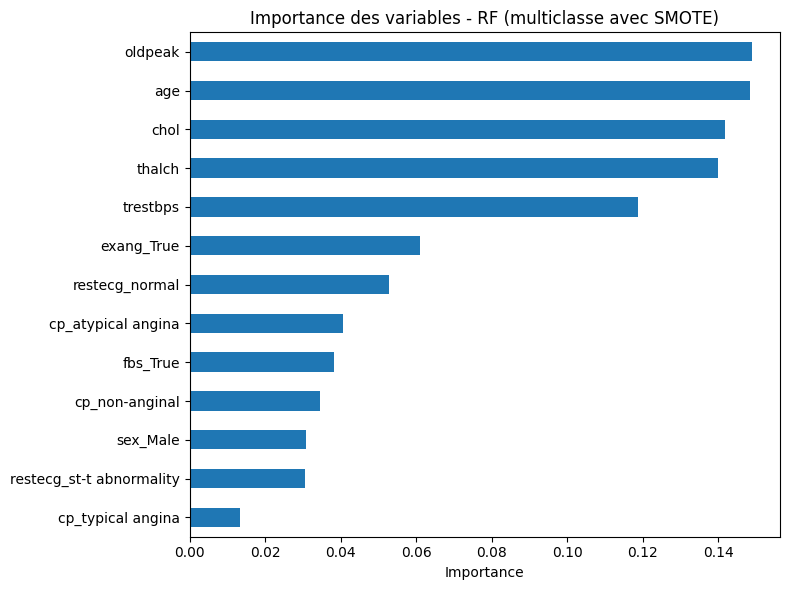

In [22]:
# Importance des variables
importances = pd.Series(rf_multi_smote.feature_importances_, index=X.columns)
importances_sorted = importances.sort_values(ascending=True)

plt.figure(figsize=(8, 6))
importances_sorted.plot(kind='barh')
plt.title('Importance des variables - RF (multiclasse avec SMOTE)')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

Observations
Classification binaire

    Les modèles détectent très efficacement les patients malades.

    Peu de faux négatifs — critique en contexte médical.

    Variables les plus influentes :

        Angine asymptomatique

        Oldpeak (dépression post-effort)

        Sexe masculin

        Exang (angine induite par effort)

Classification multiclasses

    Les classes 2, 3, 4 sont mal reconnues, surtout à cause :

        Du déséquilibre des classes

        Du peu d’exemples représentatifs

    SMOTE peut améliorer les performances mais ne règle pas tout :

        Classe 4 reste trop rare pour un apprentissage fiable

        Risque de surajustement si mal calibré


    Utiliser la classification binaire en production si l'objectif est : « malade ou non ? »

    Pour une prédiction fine des stades, il faudra :

        Plus de données pour les classes rares

        Des modèles robustes + équilibrage (SMOTE + RandomForest/XGBoost)

        Une potentielle approche hiérarchique : binaire puis multiclasses sur les malades

